In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")


Device utilisé: cuda


In [ ]:
class ContrailsDataset(Dataset):
    """
    Dataset pour charger les images PNG et leurs labels .npy
    """
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir: Chemin vers SingleFrame_PNG/
            split: 'train', 'validation', ou 'test'
            transform: Transformations à appliquer aux images
        """
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform
        
       
        images_dir = self.data_dir / split / 'images'
        gt_dir = self.data_dir / split / 'ground_truth'
        

        self.image_files = sorted(list(images_dir.glob('*.png')) + list(images_dir.glob('*.jpg')))
        
        print(f"Trouvé {len(self.image_files)} images dans {split}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
 
        gt_path = self.data_dir / self.split / 'ground_truth' / (img_path.stem + '.npy')
        
        if gt_path.exists():
            gt = np.load(gt_path)
            
      
            gt = np.asarray(gt)
            
            # Si c'est un masque 2D (ou plus), on vérifie s'il y a des contrails
            if gt.ndim >= 2:
                # Si c'est un masque de segmentation, on vérifie s'il y a des pixels > 0.5
                label = 1 if np.any(gt > 0.5) else 0

            else:
                # Scalaire (ndim == 0)
                label = int(gt.item())
        else:
            # Si pas de ground truth, label par défaut
            label = 0
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)


In [3]:
# Configuration
DATA_DIR = r'/kaggle/input/opencontrails/SingleFrame_PNG'  
BATCH_SIZE = 32
IMAGE_SIZE = 224 


train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])


val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ContrailsDataset(DATA_DIR, split='train', transform=train_transform)
val_dataset = ContrailsDataset(DATA_DIR, split='validation', transform=val_transform)
test_dataset = ContrailsDataset(DATA_DIR, split='test', transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Trouvé 17907 images dans train
Trouvé 2238 images dans validation
Trouvé 2239 images dans test
Train batches: 560
Validation batches: 70
Test batches: 70


In [4]:
class ContrailsClassifier(nn.Module):
    """
    Classificateur basé sur ResNet50 pré-entraîné
    """
    def __init__(self, num_classes=2, pretrained=True):
        super(ContrailsClassifier, self).__init__()
        
        # Charger ResNet50 pré-entraîné
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Remplacer la dernière couche pour notre classification binaire
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


model = ContrailsClassifier(num_classes=2, pretrained=True)
model = model.to(device)

print(f"Modèle créé et déplacé sur {device}")
print(f"Nombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 


Modèle créé et déplacé sur cuda
Nombre de paramètres: 23,512,130


In [5]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque avec barre de progression"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
       
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Évalue le modèle sur le set de validation avec barre de progression"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1


In [6]:

NUM_EPOCHS = 10
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

print("Début de l'entraînement...")
print("-" * 60)

for epoch in range(NUM_EPOCHS):

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    

    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("-" * 60)

print("Entraînement terminé!")


Début de l'entraînement...
------------------------------------------------------------


Epoch 1/10
  Train - Loss: 0.5675, Acc: 0.7149
  Val   - Loss: 0.5186, Acc: 0.7592, F1: 0.7254
------------------------------------------------------------


Epoch 2/10
  Train - Loss: 0.5080, Acc: 0.7604
  Val   - Loss: 0.4429, Acc: 0.7971, F1: 0.7444
------------------------------------------------------------


Epoch 3/10
  Train - Loss: 0.4698, Acc: 0.7814
  Val   - Loss: 0.4499, Acc: 0.7797, F1: 0.7442
------------------------------------------------------------


Epoch 4/10
  Train - Loss: 0.4496, Acc: 0.7951
  Val   - Loss: 0.4714, Acc: 0.7735, F1: 0.7486
------------------------------------------------------------


Epoch 5/10
  Train - Loss: 0.4339, Acc: 0.8020
  Val   - Loss: 0.4219, Acc: 0.8074, F1: 0.7638
------------------------------------------------------------


Epoch 6/10
  Train - Loss: 0.4230, Acc: 0.8088
  Val   - Loss: 0.4028, Acc: 0.8222, F1: 0.8049
------------------------------------------------------------


Epoch 7/10
  Train - Loss: 0.4167, Acc: 0.8112
  Val   - Loss: 0.3784, Acc: 0.8311, F1: 0.7966
------------------------------------------------------------


Epoch 8/10
  Train - Loss: 0.4167, Acc: 0.8138
  Val   - Loss: 0.3982, Acc: 0.8208, F1: 0.7702
------------------------------------------------------------


Epoch 9/10
  Train - Loss: 0.4085, Acc: 0.8164
  Val   - Loss: 0.3607, Acc: 0.8436, F1: 0.8134
------------------------------------------------------------


Epoch 10/10
  Train - Loss: 0.4025, Acc: 0.8229
  Val   - Loss: 0.3475, Acc: 0.8521, F1: 0.8264
------------------------------------------------------------
Entraînement terminé!


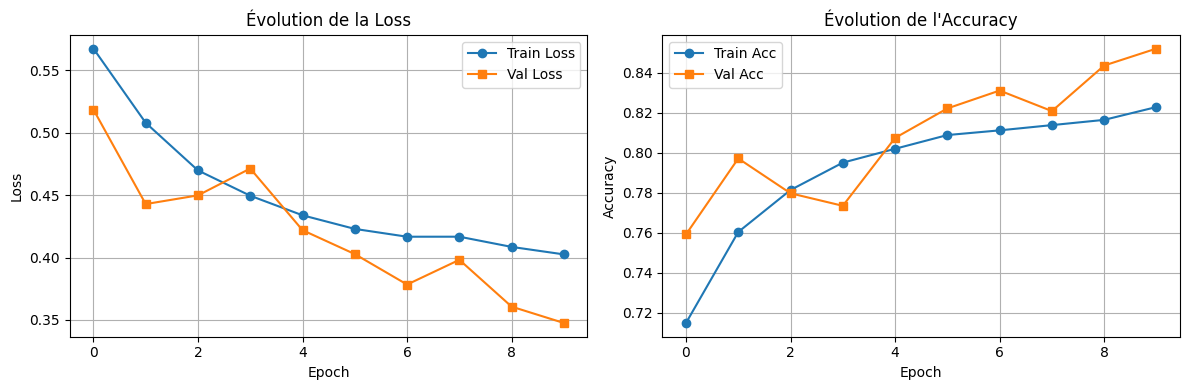

In [7]:
# Visualiser l'évolution de l'entraînement
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Évolution de l\'Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Évaluer sur le test set
test_loss, test_acc, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)

print("=" * 60)
print("RÉSULTATS SUR LE TEST SET")
print("=" * 60)
print(f"Loss:        {test_loss:.4f}")
print(f"Accuracy:    {test_acc:.4f}")
print(f"Precision:   {test_precision:.4f}")
print(f"Recall:      {test_recall:.4f}")
print(f"F1-Score:    {test_f1:.4f}")
print("=" * 60)


RÉSULTATS SUR LE TEST SET
Loss:        0.3909
Accuracy:    0.8312
Precision:   0.8178
Recall:      0.6111
F1-Score:    0.6995


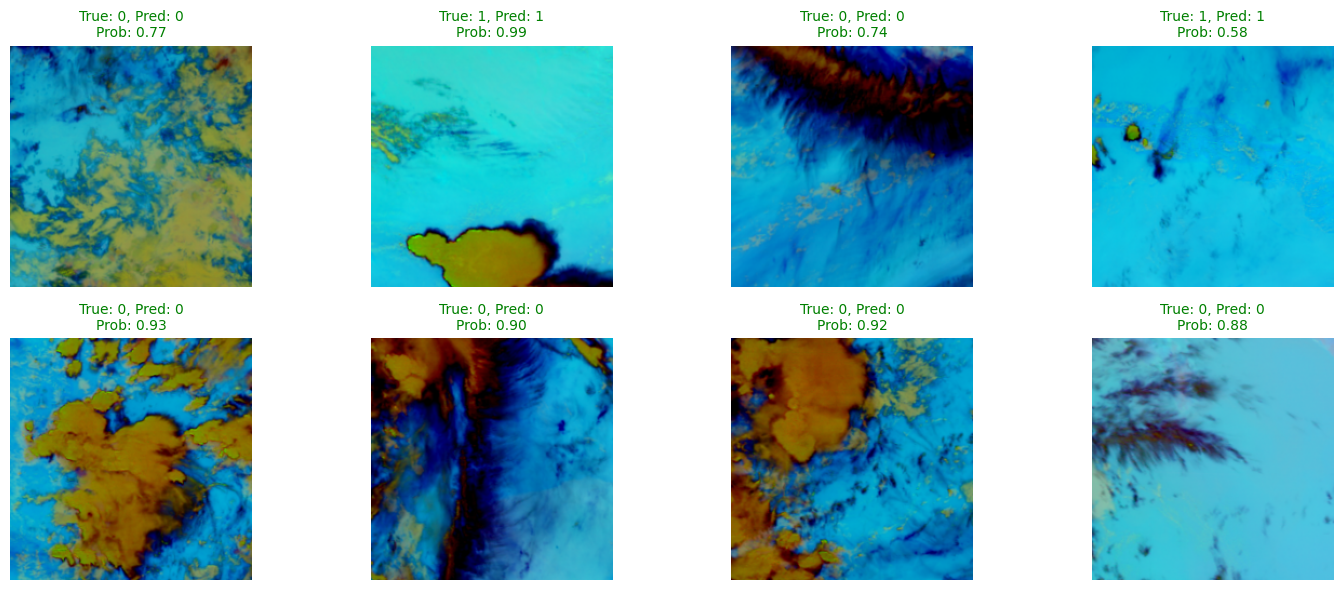

In [9]:
def visualize_predictions(model, test_loader, device, num_samples=8):
    """Visualise quelques prédictions du modèle"""
    model.eval()
    
    # Récupérer un batch
    images, labels = next(iter(test_loader))
    images = images.to(device)
    

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
    
   
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 6))
    axes = axes.flatten()
    
    # Dénormaliser pour l'affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu() * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        true_label = labels[i].item()
        pred_label = preds[i].item()
        prob = probs[i][pred_label].item()
        
        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nProb: {prob:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiser quelques prédictions
visualize_predictions(model, test_loader, device, num_samples=8)


In [10]:
# Sauvegarder le modèle entraîné
model_save_path = 'contrails_classifier_resnet50.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1
    }
}, model_save_path)

print(f"Modèle sauvegardé dans: {model_save_path}")


Modèle sauvegardé dans: contrails_classifier_resnet50.pth


Data type: <class 'numpy.ndarray'>
Shape: (256, 256, 1)


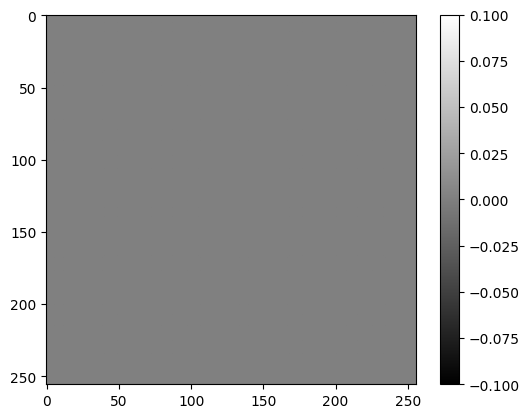

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your npy file
file_path = '/kaggle/input/opencontrails/SingleFrame_PNG/train/ground_truth/1000216489776414077.npy'

# Load the npy file
data = np.load(file_path)

# Check its shape and type
print("Data type:", type(data))
print("Shape:", data.shape)

# If it's an image (2D or 3D array), visualize it
plt.imshow(data, cmap='gray')  # or cmap='viridis' depending on your data
plt.colorbar()
plt.show()


##  Étape 10: Grad-CAM - Visualisation des Zones d'Attention

**Grad-CAM** (Gradient-weighted Class Activation Mapping) montre **où** le modèle regarde dans l'image pour faire sa prédiction. 


In [24]:
class GradCAM:
    """
    Implémentation de Grad-CAM pour visualiser les zones d'attention du modèle
    Version simplifiée et robuste
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.forward_hook = None
        self.backward_hook = None
        
        # Hook pour capturer les activations (forward)
        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        
        # Hook pour capturer les gradients (backward)
        # Essayer d'abord register_backward_hook, puis register_full_backward_hook si erreur
        try:
            self.backward_hook = self.target_layer.register_backward_hook(self.save_gradient)
        except RuntimeError:
            # Si register_backward_hook échoue, essayer register_full_backward_hook
            try:
                self.backward_hook = self.target_layer.register_full_backward_hook(self.save_gradient)
            except RuntimeError as e:
                print(f"Attention: Impossible d'enregistrer le hook backward: {e}")
                print("Grad-CAM fonctionnera en mode limité.")
    
    def save_activation(self, module, input, output):
        """Capture les activations lors du forward pass"""
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        """Capture les gradients lors du backward pass"""
        # grad_output peut être un tuple ou directement un tensor
        if grad_output is not None:
            if isinstance(grad_output, tuple):
                if len(grad_output) > 0 and grad_output[0] is not None:
                    self.gradients = grad_output[0]
            else:
                self.gradients = grad_output
    
    def generate_cam(self, input_image, class_idx=None):
        """
        Génère la heatmap Grad-CAM pour une image
        """
        self.model.eval()
        self.gradients = None
        self.activations = None
        
        # S'assurer que l'image nécessite des gradients
        if not input_image.requires_grad:
            input_image = input_image.requires_grad_(True)
        
        # Forward pass
        output = self.model(input_image)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        # Vérifier que les gradients et activations sont capturés
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients ou activations non capturés. Vérifiez le hook.")
        
        # Calculer les poids (moyenne des gradients sur les dimensions spatiales)
        gradients = self.gradients
        activations = self.activations
        
        # Si gradients/activations sont des tuples, prendre le premier élément
        if isinstance(gradients, tuple):
            gradients = gradients[0]
        if isinstance(activations, tuple):
            activations = activations[0]
        
        # Calculer les poids - dimensions typiques: [batch, channels, height, width]
        if gradients.dim() == 4:
            weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        else:
            weights = torch.mean(gradients, dim=(1, 2), keepdim=True)
        
        # Générer la heatmap
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam)  # ReLU pour ne garder que les contributions positives
        
        # Normaliser
        cam = cam.squeeze()
        if cam.max() > 0:
            cam = cam / (cam.max() + 1e-8)
        
        # Redimensionner à la taille de l'image originale
        from torch.nn import functional as F
        cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), 
                                   size=(input_image.shape[2], input_image.shape[3]), 
                                   mode='bilinear', align_corners=False)
        
        return cam_resized.squeeze().cpu().detach().numpy()
    
    def __del__(self):
        """Nettoyer les hooks lors de la destruction de l'objet"""
        if self.forward_hook is not None:
            self.forward_hook.remove()
        if self.backward_hook is not None:
            self.backward_hook.remove()

# Créer l'objet Grad-CAM pour la dernière couche convolutive de ResNet50
# (layer4 est la dernière couche de blocs résiduels)
try:
    target_layer = model.backbone.layer4[-1]
    gradcam = GradCAM(model, target_layer)
    print("Grad-CAM initialisé avec succès !")
except RuntimeError as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("Tentative avec une approche alternative...")
    # Alternative: utiliser la dernière couche convolutive du dernier bloc
    target_layer = model.backbone.layer4[-1].conv3
    gradcam = GradCAM(model, target_layer)
    print("Grad-CAM initialisé avec la couche alternative !")


Grad-CAM initialisé avec succès !


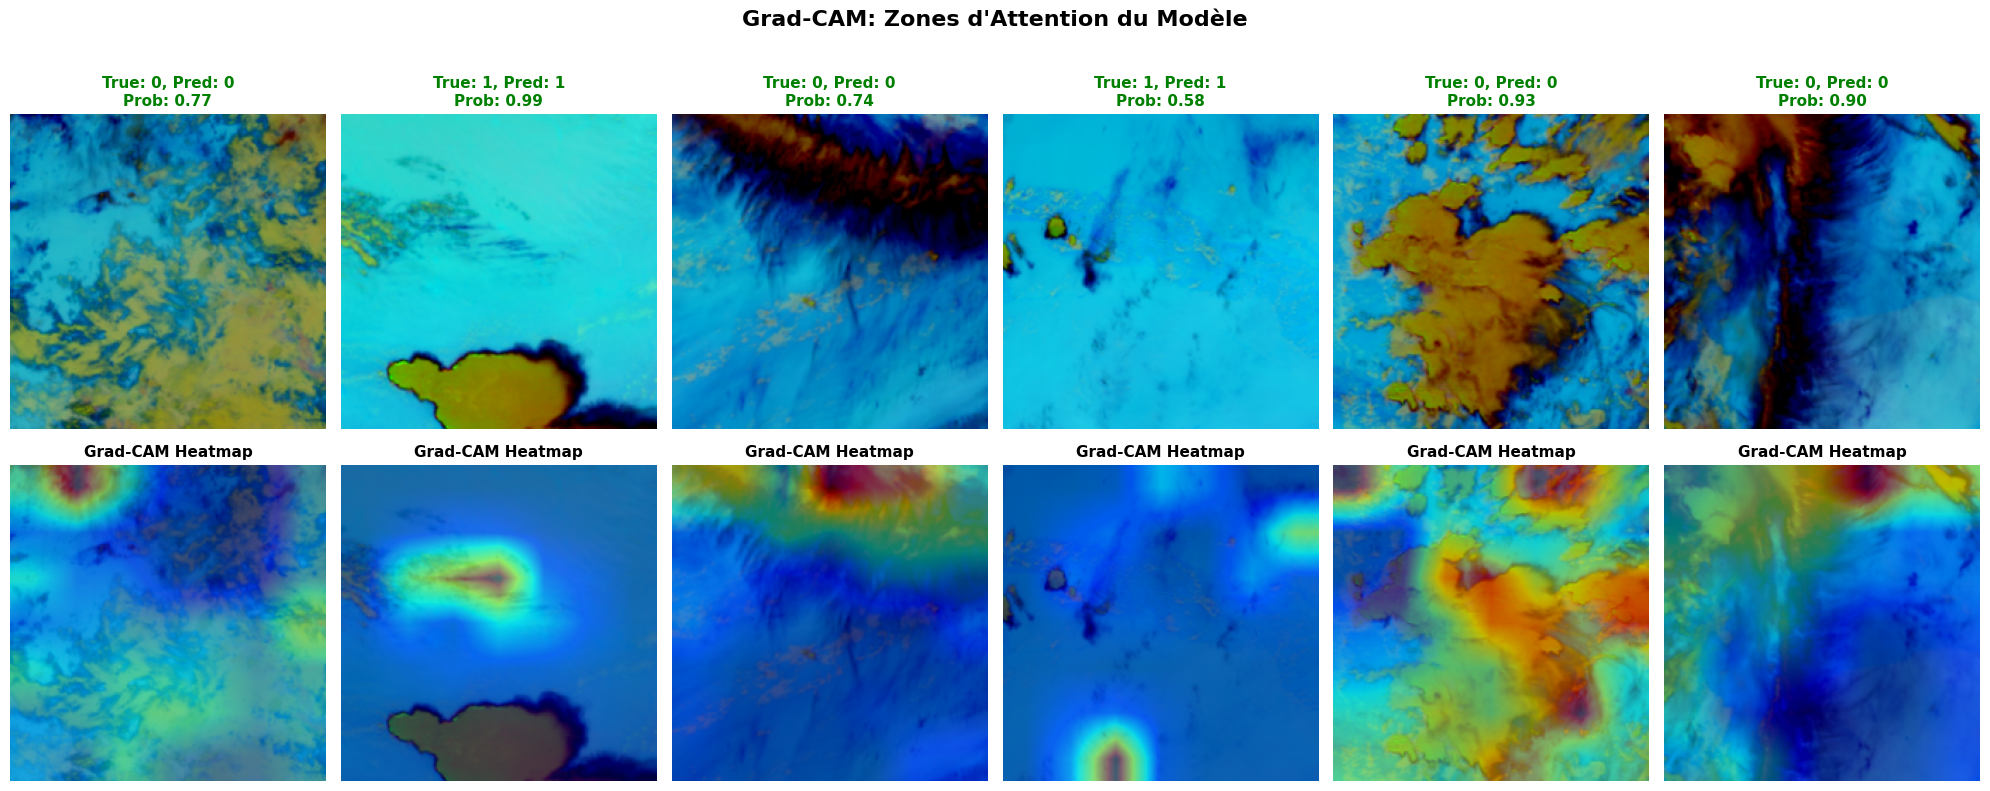

In [25]:
def visualize_gradcam(model, test_loader, gradcam, device, num_samples=6):
    """
    Visualise les prédictions avec les heatmaps Grad-CAM
    """
    model.eval()
    
    # Récupérer un batch
    images, labels = next(iter(test_loader))
    images = images.to(device)
    
    # Prédictions (sans no_grad car on aura besoin des gradients pour Grad-CAM)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    probs = torch.softmax(outputs, dim=1)
    
    # Sélectionner des échantillons variés (corrects et incorrects)
    num_samples = min(num_samples, len(images))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    if num_samples == 1:
        axes = axes.reshape(2, 1)
    
    # Dénormaliser pour l'affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    for i in range(num_samples):
        img = images[i:i+1].requires_grad_(True)  # Nécessaire pour Grad-CAM
        true_label = labels[i].item()
        pred_label = preds[i].item()
        prob = probs[i][pred_label].item()
        
        # Générer la heatmap Grad-CAM
        cam = gradcam.generate_cam(img, class_idx=pred_label)
        
        # Dénormaliser l'image pour affichage
        img_display = images[i].cpu() * std.cpu() + mean.cpu()
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.permute(1, 2, 0).numpy()
        
        # Afficher l'image originale
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f'True: {true_label}, Pred: {pred_label}\nProb: {prob:.2f}', 
                            color='green' if true_label == pred_label else 'red',
                            fontsize=11, fontweight='bold')
        axes[0, i].axis('off')
        
        # Afficher l'image avec heatmap
        axes[1, i].imshow(img_display)
        axes[1, i].imshow(cam, cmap='jet', alpha=0.5, interpolation='bilinear')
        axes[1, i].set_title('Grad-CAM Heatmap', fontsize=11, fontweight='bold')
        axes[1, i].axis('off')
    
    plt.suptitle('Grad-CAM: Zones d\'Attention du Modèle', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Visualiser avec Grad-CAM
visualize_gradcam(model, test_loader, gradcam, device, num_samples=6)


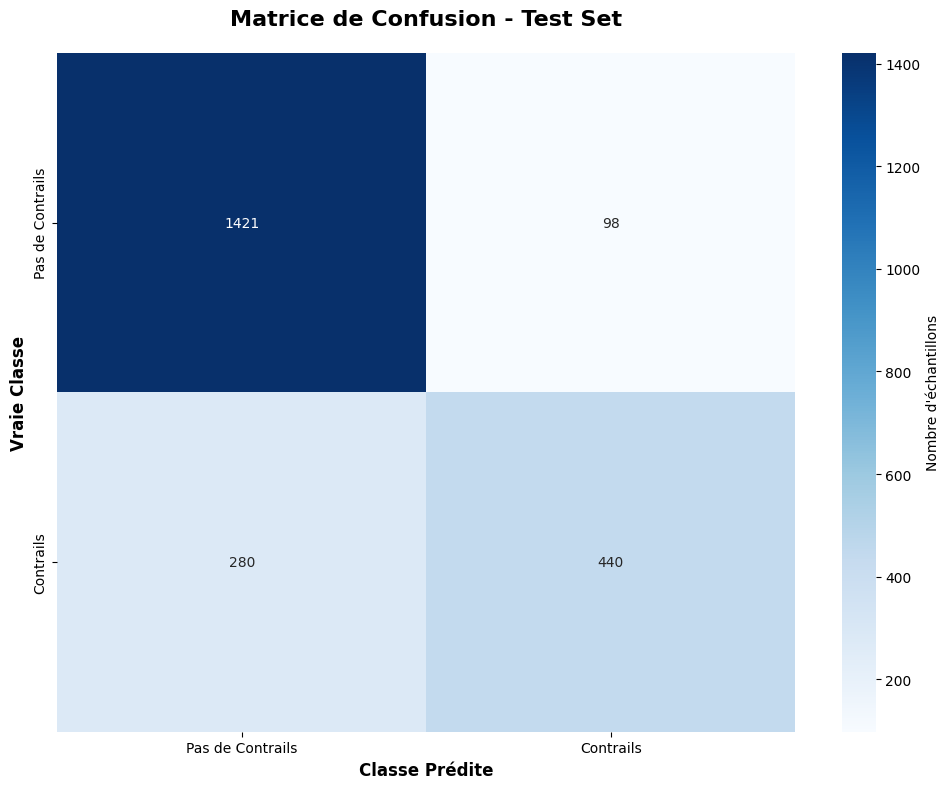

RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

Pas de Contrails     0.8354    0.9355    0.8826      1519
       Contrails     0.8178    0.6111    0.6995       720

        accuracy                         0.8312      2239
       macro avg     0.8266    0.7733    0.7911      2239
    weighted avg     0.8297    0.8312    0.8237      2239


📈 STATISTIQUES DÉTAILLÉES:
  Vrais Négatifs (TN): 1421 - Correctement identifiés comme 'Pas de Contrails'
  Faux Positifs (FP):    98 - Prédits 'Contrails' mais c'est faux
  Faux Négatifs (FN):   280 - Prédits 'Pas de Contrails' mais c'est faux
  Vrais Positifs (TP):  440 - Correctement identifiés comme 'Contrails'

  Taux d'erreur: 16.88%


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculer toutes les prédictions sur le test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pas de Contrails', 'Contrails'],
            yticklabels=['Pas de Contrails', 'Contrails'],
            cbar_kws={'label': 'Nombre d\'échantillons'})
plt.title('Matrice de Confusion - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Vraie Classe', fontsize=12, fontweight='bold')
plt.xlabel('Classe Prédite', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(all_labels, all_preds, 
                          target_names=['Pas de Contrails', 'Contrails'],
                          digits=4))
print("=" * 70)

# Statistiques supplémentaires
tn, fp, fn, tp = cm.ravel()
print(f"\n📈 STATISTIQUES DÉTAILLÉES:")
print(f"  Vrais Négatifs (TN): {tn:4d} - Correctement identifiés comme 'Pas de Contrails'")
print(f"  Faux Positifs (FP):  {fp:4d} - Prédits 'Contrails' mais c'est faux")
print(f"  Faux Négatifs (FN):  {fn:4d} - Prédits 'Pas de Contrails' mais c'est faux")
print(f"  Vrais Positifs (TP): {tp:4d} - Correctement identifiés comme 'Contrails'")
print(f"\n  Taux d'erreur: {(fp + fn) / len(all_labels) * 100:.2f}%")


Nombre total d'erreurs: 378 / 2239
Taux d'erreur: 16.88%



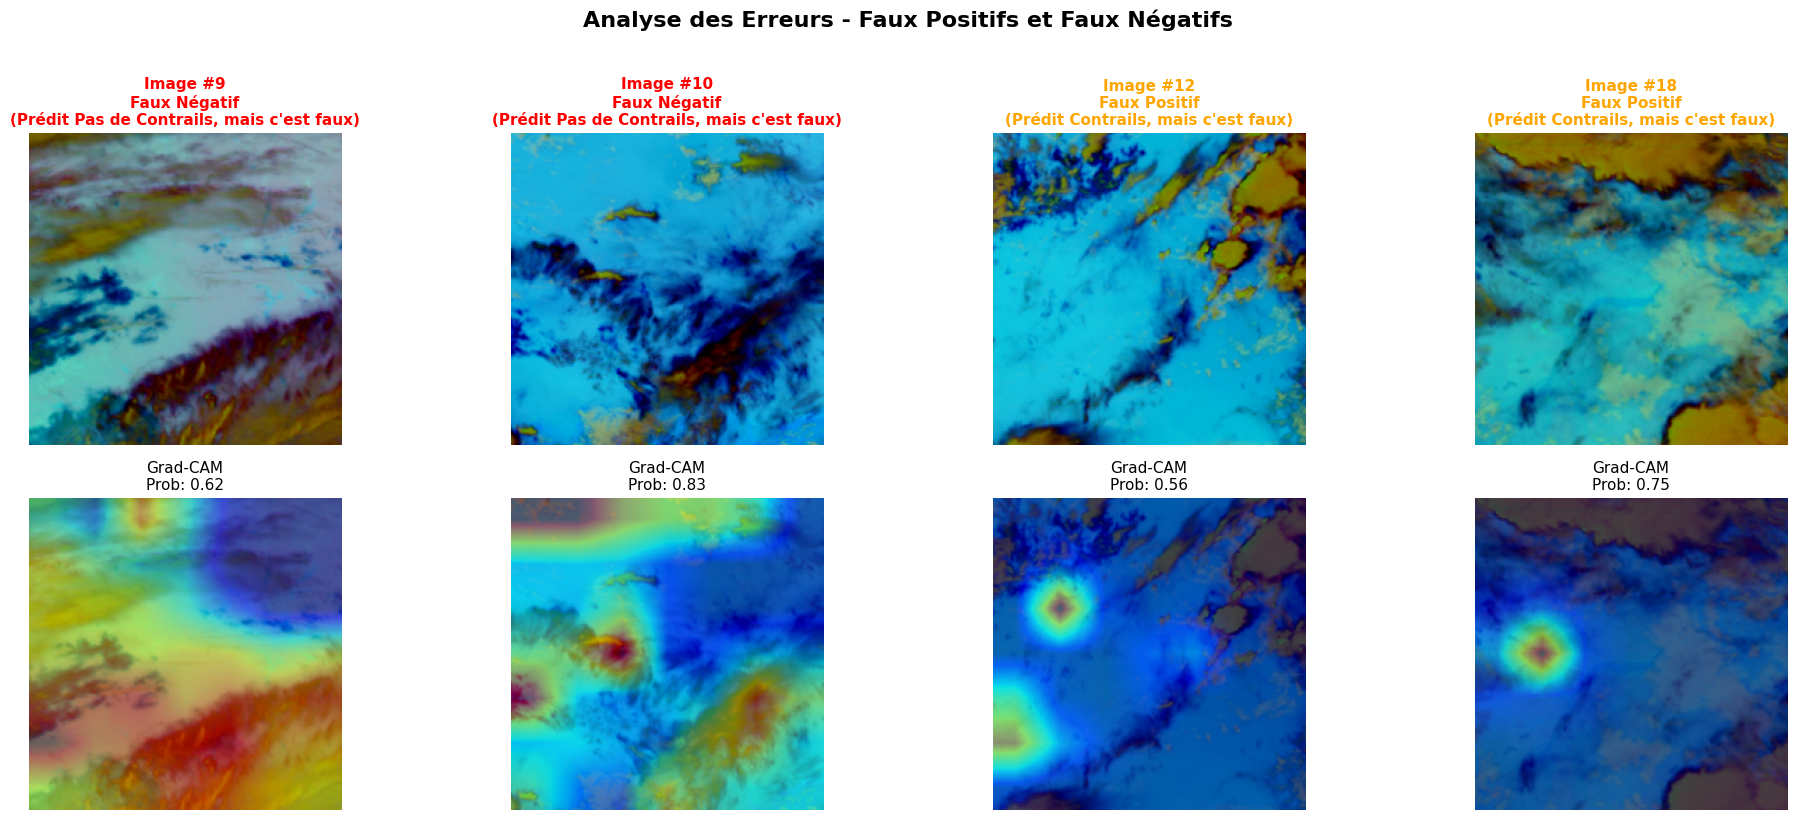

📊 RÉPARTITION DES ERREURS:
  Faux Positifs: 98 (25.9% des erreurs)
  Faux Négatifs: 280 (74.1% des erreurs)


In [28]:
def analyze_errors(model, test_dataset, all_preds, all_labels, device, num_examples=4):
    """
    Analyse et visualise les erreurs du modèle
    """
    model.eval()
    
    # Trouver les indices des erreurs
    errors = []
    for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
        if pred != label:
            errors.append(i)
    
    print(f"Nombre total d'erreurs: {len(errors)} / {len(all_labels)}")
    print(f"Taux d'erreur: {len(errors) / len(all_labels) * 100:.2f}%\n")
    
    if len(errors) == 0:
        print("🎉 Aucune erreur trouvée !")
        return
    
    # Sélectionner quelques exemples d'erreurs
    num_examples = min(num_examples, len(errors))
    error_indices = errors[:num_examples]
    
    fig, axes = plt.subplots(2, num_examples, figsize=(20, 8))
    if num_examples == 1:
        axes = axes.reshape(2, 1)
    
    # Dénormaliser pour l'affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for idx, error_idx in enumerate(error_indices):
        # Charger l'image
        image, true_label = test_dataset[error_idx]
        pred_label = all_preds[error_idx]
        prob = all_probs[error_idx][pred_label]
        
        # Dénormaliser
        img_display = image * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.permute(1, 2, 0).numpy()
        
        # Déterminer le type d'erreur
        if true_label == 0 and pred_label == 1:
            error_type = "Faux Positif\n(Prédit Contrails, mais c'est faux)"
            color = 'orange'
        else:
            error_type = "Faux Négatif\n(Prédit Pas de Contrails, mais c'est faux)"
            color = 'red'
        
        # Afficher
        axes[0, idx].imshow(img_display)
        axes[0, idx].set_title(f'Image #{error_idx}\n{error_type}', 
                              color=color, fontsize=11, fontweight='bold')
        axes[0, idx].axis('off')
        
        # Afficher avec Grad-CAM
        image_tensor = image.unsqueeze(0).to(device)
        cam = gradcam.generate_cam(image_tensor, class_idx=pred_label)
        
        axes[1, idx].imshow(img_display)
        axes[1, idx].imshow(cam, cmap='jet', alpha=0.5, interpolation='bilinear')
        axes[1, idx].set_title(f'Grad-CAM\nProb: {prob:.2f}', fontsize=11)
        axes[1, idx].axis('off')
    
    plt.suptitle('Analyse des Erreurs - Faux Positifs et Faux Négatifs', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistiques par type d'erreur
    fp_count = sum(1 for i in errors if all_labels[i] == 0 and all_preds[i] == 1)
    fn_count = sum(1 for i in errors if all_labels[i] == 1 and all_preds[i] == 0)
    
    print(f"📊 RÉPARTITION DES ERREURS:")
    print(f"  Faux Positifs: {fp_count} ({fp_count/len(errors)*100:.1f}% des erreurs)")
    print(f"  Faux Négatifs: {fn_count} ({fn_count/len(errors)*100:.1f}% des erreurs)")

# Analyser les erreurs
analyze_errors(model, test_dataset, all_preds, all_labels, device, num_examples=4)


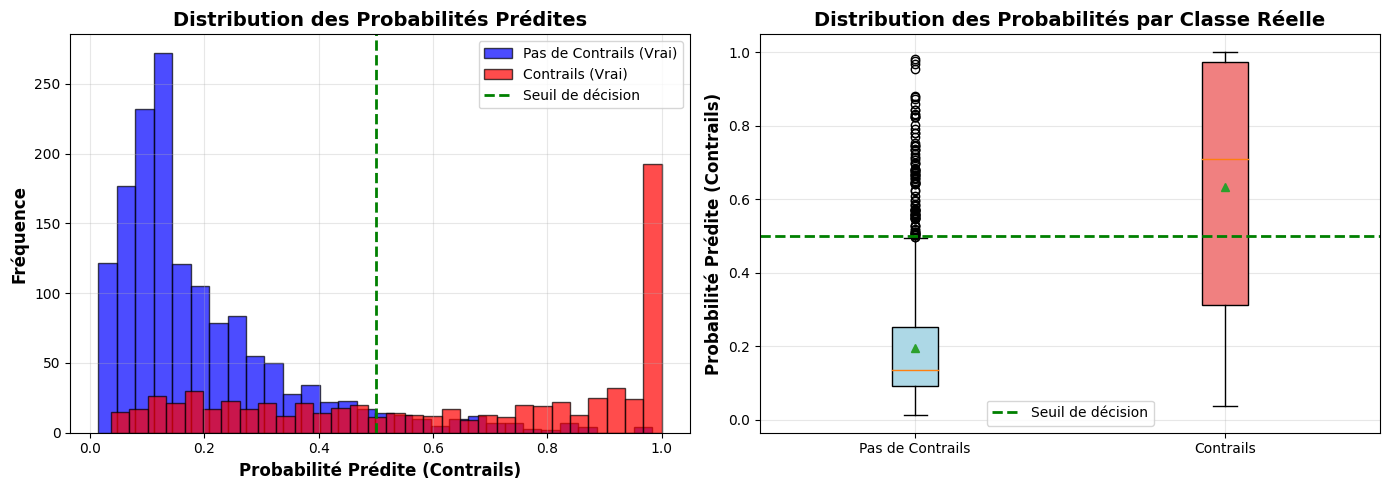

📊 ANALYSE DE CONFIANCE:
  Probabilité moyenne (Pas de Contrails): 0.196
  Probabilité moyenne (Contrails): 0.634
  Écart-type (Pas de Contrails): 0.164
  Écart-type (Contrails): 0.329
  Nombre d'échantillons (Pas de Contrails): 1519
  Nombre d'échantillons (Contrails): 720


In [31]:
# Analyser la distribution des probabilités
all_probs_array = np.array(all_probs)
all_labels_array = np.array(all_labels)

# S'assurer que prob_contrails est un array 1D
if all_probs_array.ndim == 2:
    prob_contrails = all_probs_array[:, 1]  # Probabilité de la classe "Contrails"
else:
    prob_contrails = all_probs_array.flatten()

# Filtrer les données par classe
prob_class_0 = prob_contrails[all_labels_array == 0]
prob_class_1 = prob_contrails[all_labels_array == 1]

# Vérifier qu'on a des données
if len(prob_class_0) == 0 or len(prob_class_1) == 0:
    print("⚠️ Attention: Une des classes est vide. Impossible de créer les visualisations.")
else:
    # Créer la visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des probabilités
    axes[0].hist(prob_class_0, bins=30, alpha=0.7, 
                label='Pas de Contrails (Vrai)', color='blue', edgecolor='black')
    axes[0].hist(prob_class_1, bins=30, alpha=0.7, 
                label='Contrails (Vrai)', color='red', edgecolor='black')
    axes[0].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Seuil de décision')
    axes[0].set_xlabel('Probabilité Prédite (Contrails)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution des Probabilités Prédites', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot par classe réelle
    data_to_plot = [prob_class_0, prob_class_1]
    bp = axes[1].boxplot(data_to_plot, labels=['Pas de Contrails', 'Contrails'], 
                        patch_artist=True, showmeans=True)
    axes[1].axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Seuil de décision')
    axes[1].set_ylabel('Probabilité Prédite (Contrails)', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution des Probabilités par Classe Réelle', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Colorier les box plots
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques de confiance
    print("📊 ANALYSE DE CONFIANCE:")
    print(f"  Probabilité moyenne (Pas de Contrails): {prob_class_0.mean():.3f}")
    print(f"  Probabilité moyenne (Contrails): {prob_class_1.mean():.3f}")
    print(f"  Écart-type (Pas de Contrails): {prob_class_0.std():.3f}")
    print(f"  Écart-type (Contrails): {prob_class_1.std():.3f}")
    print(f"  Nombre d'échantillons (Pas de Contrails): {len(prob_class_0)}")
    print(f"  Nombre d'échantillons (Contrails): {len(prob_class_1)}")
